In [1]:
import os
from transformers import DetrImageProcessor, DetrForObjectDetection
import cv2
import shutil
from helper import *
import numpy as np
import torch
from scipy import spatial
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bd_configPath = 'models/bib_detector/RBNR2_custom-yolov4-tiny-detector.cfg'
bd_weightsPath = 'models/bib_detector/RBNR2_custom-yolov4-tiny-detector_best.weights'
bd_classes = ['bib']
bd = BibDetector(bd_configPath, bd_weightsPath, bd_classes)

human_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
human_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

extract_dir = "/Users/arpitsharma/Downloads/Extract"
organize_dir = "/Users/arpitsharma/Downloads/organized_photos"

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [3]:
path_to_file = "/Users/arpitsharma/Downloads/hell_race/Copy of SSU22-1691.jpg"

img = cv2.cvtColor(cv2.imread(path_to_file), cv2.COLOR_BGR2RGB)

runner = Runner(filename=path_to_file, img=img)

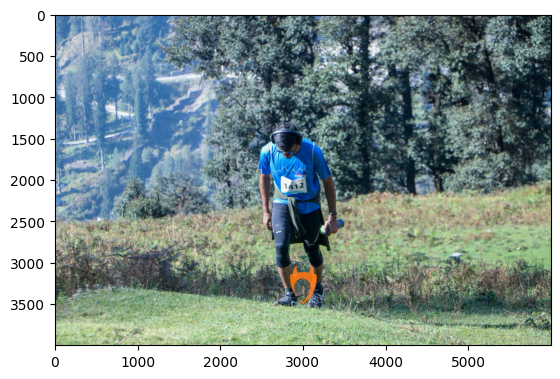

In [ ]:
plt.imshow(img)

In [5]:
inputs = human_processor(images=img, return_tensors="pt")
outputs = human_model(**inputs)

In [6]:
target_sizes = torch.tensor([img.shape[:2]])
results = human_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

In [7]:
results

{'scores': tensor([0.9998, 0.9629], grad_fn=<IndexBackward0>),
 'labels': tensor([ 1, 34]),
 'boxes': tensor([[2452.0688, 1315.0500, 3420.5510, 3557.6707],
         [2811.7029, 3019.2576, 3150.1802, 3513.7710]],
        grad_fn=<IndexBackward0>)}

In [8]:
score, label, box = results["scores"], results["labels"], results["boxes"]

i = 0

if human_model.config.id2label[label[i].item()] == "person":
    hbox = [int(i) for i in box[i].tolist()]
    runner.body_location = hbox
    runner.detect_face()
    body = img[hbox[1]:hbox[3], hbox[0]:hbox[2]]
else:
    print(False)

1/1 [==============================] - 0s 44ms/step


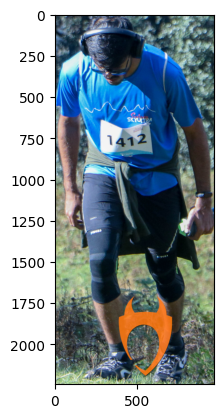

In [9]:
plt.imshow(body)

In [24]:
bib_detections_probables = bd.detect(body, 0.25, swapRB=True) + bd.detect(body, 0.25, swapRB=False)

In [25]:
bib_detections = []
body_box = runner.body_location

for bib_box in bib_detections_probables:
    (x, y, w, h) = bib_box
    
    x = x + body_box[0]
    y = y + body_box[1]
    
    if x >= body_box[0] and y >= body_box[1] and x + w <= body_box[2] and y + h <= body_box[3]:
        bib_detections.append([x, y, w, h])

In [26]:
bib_detections

([[284, 688, 303, 138]], [[2736, 2003, 303, 138]])

In [19]:
for bib_box in bib_detections:
    (x1, y1, x2, y2) = convert_opencv_to_dlib(bib_box)
    runner.bib_location = (x1, y1, x2, y2)
    
    bib_number = bd.process_image(img[y1:y2, x1:x2])

/Users/arpitsharma/miniconda3/envs/vision/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


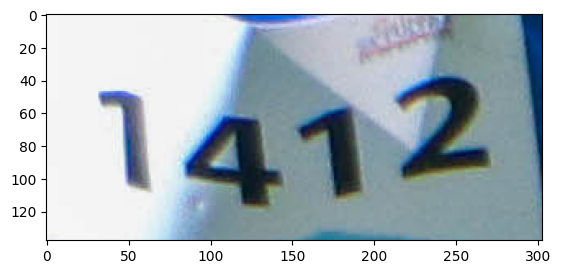

In [20]:
plt.imshow(img[y1:y2, x1:x2])

In [22]:
bib_number = bd.process_image(img[y1:y2, x1:x2])
print(bib_number)

1412


In [23]:
runner.bib_number = bib_number

In [3]:
extract_dir = "/Users/arpitsharma/Downloads/hell_race"
organize_dir = "/Users/arpitsharma/Downloads/organized_photos"

participants = {}
unidentified_participants = {}

for i, filename in enumerate(os.listdir(extract_dir)):
    
    print("*****File:", filename)
    filenumber = i + 1
    human = 0
    full_image = False
    bib = 0

    img = cv2.cvtColor(cv2.imread(os.path.join(extract_dir, filename)), cv2.COLOR_BGR2RGB)

    inputs = human_processor(images=img, return_tensors="pt")
    outputs = human_model(**inputs)

    target_sizes = torch.tensor([img.shape[:2]])
    results = human_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)

    if len(results) == 0:
        print(f"[ERROR] {filenumber} {filename} detected nothing.")
        continue
        
    bib_detections_probables = bd.detect(img, 0.20, swapRB=True) + bd.detect(img, 0.20, swapRB=False)
    bib_detections_probables = bd.de_duplicate(bib_detections_probables)
    
    print(filename, bib_detections_probables)
    
    for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):

        if human_model.config.id2label[label.item()] == "person" and round(score.item(), 3) > 0.9:
            body_box = [int(i) for i in box.tolist()]
            human += 1

            runner = Runner(filename=filename, img=img)
            runner.body_location = body_box                                                                      # Save the body box of the runner
            runner.detect_face()                                                                                 # Detects faces in the body box
            runner.embeddings()                                                                                  # Calculate the embedding vector for the detected faces
              
            bib_detections = []

            for bib_box in bib_detections_probables:
                (x, y, w, h) = bib_box

                if x >= body_box[0] and y >= body_box[1] and x + w <= body_box[2] and y + h <= body_box[3]:
                    bib_detections.append((x, y, w, h))
                    
            if len(bib_detections) == 0:
                body = img[body_box[1]:body_box[3], body_box[0]:body_box[2]]
                bib_detections = bd.detect(body, 0.2, swapRB=True, offset=body_box) + bd.detect(body, 0.2, swapRB=False, offset=body_box)
                bib_detections = bd.de_duplicate(bib_detections)
                
                print(filename, bib_detections)
  

            if len(bib_detections):

                for bib_box in bib_detections:
                    (x1, y1, x2, y2) = convert_opencv_to_dlib(bib_box)
                    runner.bib_location = (x1, y1, x2, y2)

                    bib_number = bd.process_image(img[y1:y2, x1:x2])

                    if is_correct(bib_number, event="TBTT"):
                        bib += 1
                        runner.bib_number = bib_number
                        runner.identified = True

                        if str(bib_number) not in participants.keys():
                            participants[str(bib_number)] = Participant(bib_number=bib_number)

                        participants[str(bib_number)].add_new_sample(filename, runner=runner)
                        save_photo(organize_dir, extract_dir, bib_number, filename)

                    else:
                        if filename not in unidentified_participants.keys() and runner.identified:
                            unidentified_participants[filename] = list()

                        if runner.identified:
                            unidentified_participants[filename].append(runner)
                            
                        print(f"[ERROR] {filenumber} {filename} invalid bib number range:", bib_number)
                        continue
            else:
                if filename not in unidentified_participants.keys() and runner.identified:
                    unidentified_participants[filename] = list()

                if runner.identified:
                    unidentified_participants[filename].append(runner)
                    
                print(f"[ERROR] {filenumber} {filename} no bib detected.")
                continue

    if human == 0 or bib == 0:
        err = f"[ERROR] {filenumber} {filename} no human or bib detected. humans: {human} & bibs: {bib}"
        print(err)
        continue


*****File: Copy of SSU22-2101.jpg
Copy of SSU22-2101.jpg [[1843, 4104, 409, 287]]
1/1 [==============================] - 1s 520ms/step


/Users/arpitsharma/miniconda3/envs/vision/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


*****File: 40161775_1429457957185386_5440678869071822848_o.jpg
40161775_1429457957185386_5440678869071822848_o.jpg [[390, 1555, 345, 140]]
1/1 [==============================] - 1s 503ms/step
*****File: Copy of SSU22-1640.jpg
Copy of SSU22-1640.jpg [[219, 2752, 269, 219]]
1/1 [==============================] - 1s 511ms/step
Copy of SSU22-1640.jpg []
[ERROR] 3 Copy of SSU22-1640.jpg no bib detected.
*****File: Copy of SSU22-1691.jpg
Copy of SSU22-1691.jpg []
1/1 [==============================] - 0s 10ms/step
Copy of SSU22-1691.jpg [[2736, 2003, 303, 138]]
*****File: Copy of SSU22-1692.jpg
Copy of SSU22-1692.jpg [[1639, 3302, 641, 340]]
1/1 [==============================] - 1s 709ms/step
*****File: Copy of SSU22-1489.jpg
Copy of SSU22-1489.jpg [[1783, 2181, 549, 286]]
1/1 [==============================] - 1s 518ms/step
*****File: DSC_0475.jpg
DSC_0475.jpg [[685, 2872, 504, 257], [2251, 3238, 548, 213], [3461, 3224, 492, 234]]
1/1 [==============================] - 1s 512ms/step
DSC_04

1/1 [==============================] - 1s 501ms/step
DSC_0475.jpg []
[ERROR] 7 DSC_0475.jpg no bib detected.
1/1 [==============================] - 1s 506ms/step
DSC_0475.jpg []
[ERROR] 7 DSC_0475.jpg no bib detected.
1/1 [==============================] - 1s 512ms/step
*****File: DSC_0298.jpg
DSC_0298.jpg [[4781, 2473, 301, 170]]
1/1 [==============================] - 1s 510ms/step
DSC_0298.jpg [[1784, 2640, 400, 208], [1892, 2487, 289, 257]]
1/1 [==============================] - 1s 511ms/step
DSC_0298.jpg [[427, 2393, 256, 154]]
1/1 [==============================] - 1s 507ms/step
*****File: DSC_0299.jpg
DSC_0299.jpg [[3753, 2309, 652, 375]]
1/1 [==============================] - 0s 8ms/step
DSC_0299.jpg []
[ERROR] 9 DSC_0299.jpg no bib detected.
1/1 [==============================] - 1s 515ms/step
*****File: Copy of SSU22-1114.jpg
Copy of SSU22-1114.jpg [[748, 2541, 229, 120]]
1/1 [==============================] - 1s 803ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-11

1/1 [==============================] - 1s 507ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
1/1 [==============================] - 0s 8ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
1/1 [==============================] - 1s 511ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
1/1 [==============================] - 1s 511ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
1/1 [==============================] - 1s 510ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
1/1 [==============================] - 1s 509ms/step
Copy of SSU22-1114.jpg []
[ERROR] 10 Copy of SSU22-1114.jpg no bib detected.
*****File: 40159996_1429458533851995_8739191607548444672_o.jpg
40159996_1429458533851995_8739191607548444672_o.jpg [[443, 1433, 276, 152]]
1/1 [==============================] - 1s 509ms/step
*****File: _DSC0125.jpg
_DSC01

In [4]:
unidentified_participants

{'Copy of SSU22-1640.jpg': [Copy of SSU22-1640.jpg:None:[948, 1190, 2514, 4914]:[(1635, 1443, 1968, 1861)]:None],
 'DSC_0475.jpg': [DSC_0475.jpg:None:[4383, 1270, 5733, 3961]:[(4574, 1478, 4966, 1989)]:None,
  DSC_0475.jpg:None:[2611, 1118, 3369, 3968]:[(2709, 1309, 3079, 1747)]:None,
  DSC_0475.jpg:None:[1116, 939, 2330, 3958]:[(1596, 1120, 1960, 1589)]:None,
  DSC_0475.jpg:None:[3868, 970, 4711, 3965]:[(3990, 1217, 4368, 1680)]:None],
 'Copy of SSU22-1114.jpg': [Copy of SSU22-1114.jpg:None:[323, 2133, 437, 2339]:[(392, 2151, 415, 2181)]:None,
  Copy of SSU22-1114.jpg:None:[2033, 1970, 2364, 2732]:[(2038, 1994, 2089, 2055)]:None,
  Copy of SSU22-1114.jpg:None:[1507, 1970, 1616, 2246]:[(1564, 1999, 1583, 2025)]:None,
  Copy of SSU22-1114.jpg:None:[1912, 1972, 2110, 2655]:[(2039, 1994, 2089, 2055)]:None,
  Copy of SSU22-1114.jpg:None:[1404, 1963, 1503, 2232]:[(1435, 1981, 1453, 2004)]:None,
  Copy of SSU22-1114.jpg:None:[1697, 1965, 1909, 2683]:[(1847, 2011, 1889, 2070)]:None]}

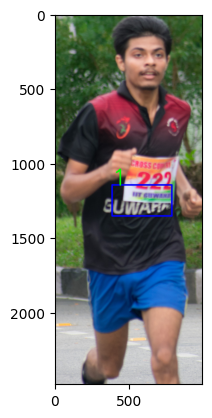

In [17]:
(x1, y1, x2, y2) = participants['UWAFF'].meta_data['DSC_0298.jpg']['body']
img = cv2.cvtColor(cv2.imread(extract_dir + '/DSC_0298.jpg'), cv2.COLOR_BGR2RGB)
img = draw_rectangle(img, [participants['UWAFF'].meta_data['DSC_0298.jpg']['bib']])
plt.imshow(img[y1:y2, x1:x2])

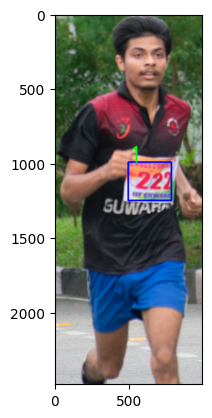

In [18]:
(x1, y1, x2, y2) = participants['222'].meta_data['DSC_0298.jpg']['body']
img = cv2.cvtColor(cv2.imread(extract_dir + '/DSC_0298.jpg'), cv2.COLOR_BGR2RGB)
img = draw_rectangle(img, [participants['222'].meta_data['DSC_0298.jpg']['bib']])
plt.imshow(img[y1:y2, x1:x2])

In [19]:
calculate_iou(participants['222'].meta_data['DSC_0298.jpg']['bib'], participants['UWAFF'].meta_data['DSC_0298.jpg']['bib'])

(0.2375584144048557, 74820, 83809)

In [12]:
extract_dir = "/Users/arpitsharma/Downloads/hell_race"
organize_dir = "/Users/arpitsharma/Downloads/organized_photos"
participants = calculate_centroid(participants)

for filename in unidentified_participants.keys():
        
    for runner in unidentified_participants[filename]:
        
        average_distances = {}
        closest = 100
        closest_bib = None

        for bib in participants.keys():
            
            if participants[bib].face_embeddings.keys():

                average_distances[bib] = spatial.distance.cosine(participants[bib].mean_embeddings, runner.face_vectors[0])

                if average_distances[bib] < closest:
                    closest_bib = bib
                    closest = average_distances[bib]

        if closest < 0.4:
            print(f"{filename} - {closest_bib}")
            save_photo(organize_dir, extract_dir, closest_bib, filename)

DSC_0475.jpg - 1298
